In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn as nn
import csv
import pandas as pd
from keras.callbacks import History
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,Input
# import tensorflow as tf
# print(tf.__file__)
from pandas import read_csv
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["axes.unicode_minus"]=False


In [2]:
def generate_diff(input_array):
    output_array = [0]  # 初始值设为0
    
    for i in range(1, len(input_array)):
        output_array.append(input_array[i] - input_array[i - 1])
        
    return output_array
    
# load data
def parse(x):
    return datetime.strptime(x, '%Y/%m/%d')

dataset = read_csv('2012-2016.csv',  parse_dates = ['Date'], date_parser=parse)
dataset.dropna()
dataset['Diff_Pct'] = dataset['Close'].pct_change()
# dataset['LogDiff'] = np.log(1+dataset['Diff'])
dataset['Diff'] = dataset['Close'].diff()
# 计算%K指标
dataset["C-L"] = dataset["Close"] - dataset["Low"]
dataset["H-L"] = dataset["High"] - dataset["Low"]
dataset["%K"] = (dataset["C-L"] / dataset["H-L"]) * 100
# 计算%D指标，这里采用3周期的简单移动平均
dataset["%D"] = dataset["%K"].rolling(window=3).mean()


# 将 Time 列转换为时间格式
dataset['Time'] = pd.to_datetime(dataset['Time'])

# 指定时间范围
# start_time = pd.to_datetime("8:44:00").time()
# end_time = pd.to_datetime("10:30:10").time()

# 选择指定时间范围内的数据
# selected_data = dataset[(dataset['Time'].dt.time >= start_time) & (dataset['Time'].dt.time <= end_time)]
selected_data=dataset

selected_data['Time'] = selected_data['Time'].dt.time

###### 新的一天，将diff设置为0
# selected_data.loc[dataset['Date'] != dataset['Date'].shift(), ['Diff','Diff_Pct']] = 0
#######
selected_data.set_index('Date', inplace=True)
selected_data.drop(columns=['Time'], inplace=True)
print(selected_data[297:301])


# # MA
# selected_data['MA_Close'] = selected_data['Close'].rolling(window=10).mean()#10分鐘平均 #加的#但我要把NAN搞掉....#所以dropnan
# selected_data['MA_Difference'] = selected_data['MA_Close'] - selected_data['MA_Close'].shift(10)
# selected_data.drop(columns=['MA_Close'], inplace=True)
# selected_data=selected_data.dropna()
# RSI
selected_data['Gain'] = selected_data['Diff'].apply(lambda x: x if x > 0 else 0)
selected_data['Loss'] = selected_data['Diff'].apply(lambda x: -x if x < 0 else 0)

# 计算平均的上涨和下跌价格变化（使用14天的时间窗口）
window = 14
selected_data['AvgGain'] = selected_data['Gain'].rolling(window=window).mean()
selected_data['AvgLoss'] = selected_data['Loss'].rolling(window=window).mean()
# 计算相对强度（RS）
selected_data['RS'] = selected_data['AvgGain'] / selected_data['AvgLoss']
# 计算RSI
selected_data['RSI'] = 100 - (100 / (1 + selected_data['RS']))
selected_data.drop(columns=['RS','AvgLoss','AvgGain','Gain', 'Loss'], inplace=True)
selected_data=selected_data.dropna()
# summarize first 5 rows
print(selected_data.head(5))
print(selected_data.shape)

# # save to file
# dataset.to_csv('Q1_dataset.csv')

              Open    High     Low   Close  TotalVolume  Diff_Pct  Diff   C-L  \
Date                                                                            
2012-01-02  6931.0  6932.0  6928.0  6930.0          783 -0.000144  -1.0   2.0   
2012-01-02  6929.0  6945.0  6929.0  6943.0         1279  0.001876  13.0  14.0   
2012-01-02  6942.0  6950.0  6942.0  6949.0         1333  0.000864   6.0   7.0   
2012-01-03  7020.0  7029.0  7020.0  7022.0         1913  0.010505  73.0   2.0   

             H-L         %K         %D  
Date                                    
2012-01-02   4.0  50.000000  29.166667  
2012-01-02  16.0  87.500000  50.000000  
2012-01-02   8.0  87.500000  75.000000  
2012-01-03   9.0  22.222222  65.740741  
              Open    High     Low   Close  TotalVolume  Diff_Pct  Diff  C-L  \
Date                                                                           
2012-01-02  7043.0  7043.0  7041.0  7041.0          131 -0.000284  -2.0  0.0   
2012-01-02  7042.0  7043.0 

In [3]:
# dataset = read_csv('2012-2016.csv')
# dataset['DateTime'] = pd.to_datetime(dataset['Date'] + ' ' + dataset['Time'])

# dataset.set_index('DateTime', inplace=True)
# dataset.drop(columns=['Time','Date'], inplace=True)

# dataset=dataset.dropna()
# # summarize first 5 rows
# # print(dataset.head(5))

# df_resampled = dataset.resample('10T').agg({
#     'Open': 'first',
#     'High': 'max',
#     'Low': 'min',
#     'Close': 'last',
#     'TotalVolume': 'sum',
# })
# df_resampled['Diff_Pct'] = df_resampled['Close'].pct_change()
# df_resampled['Diff'] = df_resampled['Close'].diff()
# df_resampled["C-L"] = df_resampled["Close"] - df_resampled["Low"]
# df_resampled["H-L"] = df_resampled["High"] - df_resampled["Low"]
# df_resampled["%K"] = (df_resampled["C-L"] / df_resampled["H-L"]) * 100
# # 计算%D指标，这里采用3周期的简单移动平均
# df_resampled["%D"] = df_resampled["%K"].rolling(window=3).mean()

# # RSI
# df_resampled['Gain'] = df_resampled['Diff'].apply(lambda x: x if x > 0 else 0)
# df_resampled['Loss'] = df_resampled['Diff'].apply(lambda x: -x if x < 0 else 0)

# # 计算平均的上涨和下跌价格变化（使用14天的时间窗口）
# window = 14
# df_resampled['AvgGain'] = df_resampled['Gain'].rolling(window=window).mean()
# df_resampled['AvgLoss'] = df_resampled['Loss'].rolling(window=window).mean()
# # 计算相对强度（RS）
# df_resampled['RS'] = df_resampled['AvgGain'] / df_resampled['AvgLoss']
# # 计算RSI
# df_resampled['RSI'] = 100 - (100 / (1 + df_resampled['RS']))
# df_resampled.drop(columns=['RS','AvgLoss','AvgGain','Gain', 'Loss'], inplace=True)

# ############
# # 計算中間通道（中線），假設使用20期的簡單移動平均
# df_resampled['SMA'] = df_resampled['Close'].rolling(window=20).mean()

# # 計算標準差，假設使用20期的標準差
# df_resampled['StdDev'] = df_resampled['Close'].rolling(window=20).std()

# # 計算上通道（上軌）
# df_resampled['UpperBand'] = df_resampled['SMA'] + (2 * df_resampled['StdDev'])

# # 計算下通道（下軌）
# df_resampled['LowerBand'] = df_resampled['SMA'] - (2 * df_resampled['StdDev'])

# # 現在你的數據集中有了布林通道的相關特徵，你可以將它們用於預測
# ###########

# # 如果你想要去掉NaN值，可以使用以下代碼
# df_resampled = df_resampled.dropna()
# print(df_resampled[:6])


# # # save to file


In [4]:
def generate_y_for10(input_array):
    output_array = [] 
    
    for i in range(0, len(input_array)):
        if input_array[i]>0:
            output_array.append(2)
        elif input_array[i]<0:
            output_array.append(1)
        else:
            output_array.append(0)
    
    return output_array

def generate_y(input_array):
    output_array = []  # 初始值设为0
    
    for i in range(0, len(input_array)-1):
        output_array.append(input_array[i+1] - input_array[i])
        
    return output_array
    

values = selected_data.values
# ensure all data is float
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
#############################################
# scaler_diff=MinMaxScaler(feature_range=(-1,1))
# t=scaler_diff.fit_transform(values[:,-1].reshape(-1,1))
# print(t)
#############################################
# normalize features
scaled = scaler.fit_transform(values)#待檢查
print(scaled)

# ##漲跌平
class_indices= generate_y_for10(values[:,5]) #diff
# 确定类别的数量
num_classes = max(class_indices) + 1

# 使用NumPy创建一个全零数组，形状为(数组长度, 类别数量)
y_label = np.zeros((len(class_indices), num_classes))
# 将对应的位置设置为1
y_label[np.arange(len(class_indices)), class_indices] = 1
# y_label=generate_y(values[:,3])#close明天相對今天增長量
print(y_label[:5])

# ##

# # 新增一列(diff 正規過後)
# # diff_n= np.array(generate_diff(scaled[:,3]))#close
# diff_n=
# # 创建布尔掩码
# mask = values[:,5] == 0.0
# # 使用布尔掩码将 b 中对应位置的值设为 0
# diff_n[mask] = 0.0
# x_label=np.hstack((scaled[:,[0,1,2,3,4,6,7]], diff_n.reshape(-1, 1)))
###########################
x_label=scaled[:,[0,1,2,3,4,6]]
# print(scaled[:5])
print(x_label[208:215])

[[0.08092308 0.07999992 0.08187127 ... 0.         0.44444442 0.6885246 ]
 [0.08061552 0.07999992 0.08156347 ... 0.6666666  0.5555556  0.6935483 ]
 [0.08030772 0.08153844 0.08094788 ... 0.5        0.3888889  0.83018863]
 ...
 [0.7633846  0.7630768  0.7651584  ... 0.5        0.5        0.4375    ]
 [0.7633846  0.7630768  0.7651584  ... 0.         0.16666666 0.46666667]
 [0.76399994 0.7633846  0.7651584  ... 0.3333333  0.2777778  0.3333333 ]]
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[0.05476928 0.05415392 0.05632496 0.05476928 0.00721838 0.5259594 ]
 [0.05476928 0.05384612 0.05570936 0.05415392 0.00386336 0.5214447 ]
 [0.05415392 0.05323076 0.05509377 0.05384612 0.00874339 0.523702  ]
 [0.05384612 0.05323076 0.05540156 0.05415392 0.00488003 0.5282167 ]
 [0.05415392 0.05384612 0.05570936 0.05476928 0.00721838 0.53047407]
 [0.05476928 0.05599999 0.05601716 0.05599999 0.04361529 0.5349887 ]
 [0.05599999 0.05599999 0.05694056 0.05569243 0.03304189 0.523702  ]]


In [5]:
# values = selected_data.values
# # ensure all data is float
# values = values.astype('float32')
# scaler = MinMaxScaler(feature_range=(0,1)).fit(values)
# x_label=scaled=scaler.transform(values)
# print(x_label[:5])
# y_label=[x[5] for x in scaled]
# y_label = y_label[1:]
# print(y_label[:5])
# print(y_label[0])

# qq=np.zeros((len(y_label),8))
# qq[:,5]=np.array(y_label)
# print(qq)
# qqq=scaler.inverse_transform(qq)
# print(qqq[0,5])

In [6]:
def split_windows(data,label, seq_length):
    x=[]
    y=[]
    for i in range(len(data)-seq_length-1):
        _x=data[i:(i+seq_length),:]
        _y=label[i+seq_length]
        x.append(_x)
        y.append(_y)
    x,y=np.array(x),np.array(y)
    # print('x.shape,y.shape=\n',x.shape,y.shape)
    return x,y

def split_data(x, y, split_ratio):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split_ratio, shuffle=False)
    return x_train, y_train, x_test, y_test



In [7]:
windowed_x, windowed_y = split_windows(x_label, y_label, 6) ##特徵序列長度#middle
print(windowed_x.shape, windowed_y.shape)

(365094, 6, 6) (365094, 3)


In [8]:
x_train, y_train, x_test, y_test = split_data(windowed_x, windowed_y, 0.2)#數據集分割 #paper test為2016年, 大概20%?
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(292075, 6, 6) (292075, 3)
(73019, 6, 6) (73019, 3)


In [9]:
model=Sequential()
model.add(LSTM(32, input_shape=(x_train.shape[1], x_train.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, input_shape=(x_train.shape[1],32),return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu',kernel_initializer='normal'))
model.add(Dense(3, activation='softmax', kernel_initializer='normal'))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

history=model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=300, verbose=1)

Epoch 1/50
974/974 [==============================] - 15s 11ms/step - loss: 1.0490 - accuracy: 0.4002 - val_loss: 1.0303 - val_accuracy: 0.4039
Epoch 2/50
974/974 [==============================] - 10s 10ms/step - loss: 1.0423 - accuracy: 0.4003 - val_loss: 1.0286 - val_accuracy: 0.4111
Epoch 3/50
974/974 [==============================] - 10s 10ms/step - loss: 1.0408 - accuracy: 0.4010 - val_loss: 1.0271 - val_accuracy: 0.4092
Epoch 4/50
974/974 [==============================] - 11s 12ms/step - loss: 1.0398 - accuracy: 0.4003 - val_loss: 1.0265 - val_accuracy: 0.4110
Epoch 5/50
974/974 [==============================] - 11s 12ms/step - loss: 1.0396 - accuracy: 0.4000 - val_loss: 1.0268 - val_accuracy: 0.4087
Epoch 6/50
974/974 [==============================] - 10s 10ms/step - loss: 1.0393 - accuracy: 0.4009 - val_loss: 1.0263 - val_accuracy: 0.4110
Epoch 7/50
974/974 [==============================] - 10s 11ms/step - loss: 1.0391 - accuracy: 0.4015 - val_loss: 1.0263 - val_accuracy:

In [10]:
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 32)             4992      
                                                                 
 dropout (Dropout)           (None, 6, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 14467 (56.51 KB)
Trainable params: 14467 (

In [11]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

2282/2282 [==============================] - 4s 2ms/step


In [12]:

# print(train_predict.shape)
# tr_predict=np.zeros((train_predict.shape[0], 8))
# te_predict=np.zeros((test_predict.shape[0], 8))

# tr_predict[:,5]=train_predict.squeeze()
# te_predict[:,5]=test_predict.squeeze()
# print(tr_predict[0])
# print(tr_predict.shape,te_predict.shape)

# tr_predict=scaler.inverse_transform(tr_predict)
# tr_predict=[x[5] for x in tr_predict]


# te_predict=scaler.inverse_transform(te_predict)
# te_predict=[x[5] for x in te_predict]
# # print(te_predict)

# print(tr_predict[:5])
# print(te_predict[:5])

In [13]:
# def custom_accuracy(array1, array2):
#     total_elements = len(array1)
#     correct_matches = 0

#     for val1, val2 in zip(array1, array2):
#         if (val1 > 0 and val2 > 0) or (val1 < 0 and val2 < 0):
#             correct_matches += 1
#         elif val1 == 0 and val2 == 0:
#             correct_matches += 1

#     accuracy = correct_matches / total_elements
#     return accuracy

# # for i in tr_predict:
# #     if i <=0 :
# #         print('y')
# yT=np.zeros((y_train.shape[0], 8))
# yT[:,5]=y_train.squeeze()
# yT=scaler.inverse_transform(yT)
# yT=[x[5] for x in yT]

# yt=np.zeros((y_test.shape[0], 8))
# yt[:,5]=y_test.squeeze()
# yt=scaler.inverse_transform(yt)
# yt=[x[5] for x in yt]

# print(custom_accuracy(tr_predict,yT))
# print(custom_accuracy(te_predict,yt))
# print(tr_predict[:5], y_train[:5])


In [14]:



    
test_predict_argmax = np.argmax(test_predict, axis=1)
# 将真实标签转换为真实的类别索引
y_test_argmax = np.argmax(y_test, axis=1)
# 计算准确率
accuracy = np.mean(y_test_argmax == test_predict_argmax)
print("Accuracy test:", accuracy)

np.save('1_test.npy', test_predict_argmax)

train_predict_argmax = np.argmax(train_predict, axis=1)
# 将真实标签转换为真实的类别索引
y_train_argmax = np.argmax(y_train, axis=1)
# 计算准确率
accuracy = np.mean(y_train_argmax == train_predict_argmax)
print("Accuracy train:", accuracy)

np.save('1_train.npy', train_predict_argmax)


idx_l=[]
for idx, value in enumerate(train_predict_argmax):
    if value == 0:
        idx_l.append(idx)

# print(idx_l)
idx_ll=[]
for idx, value in enumerate(y_train_argmax):
    if value == 0:
        idx_ll.append(idx)

print(len(idx_l),len(idx_ll))
print(len(y_train_argmax))

##drop 0.2 兩次 step=6 RSI 8:30~10:30
# Accuracy test: 0.4788966691167937
# Accuracy train: 0.47840300210843956
#全時段
# Accuracy test: 0.4549774716169764
# Accuracy train: 0.45354446631858253


Accuracy test: 0.4094824634684123
Accuracy train: 0.40392707352563556
19155 58131
292075


In [15]:
matching_elements=0
for i in range(len(train_predict_argmax)):
        if y_train_argmax[i] == 0 and train_predict_argmax[i] == 0:
            matching_elements += 1
print(matching_elements)

6678


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


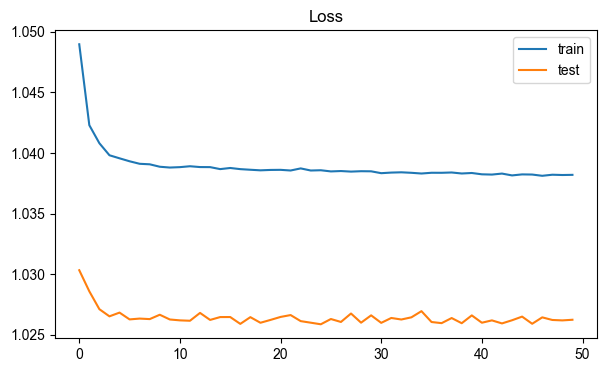

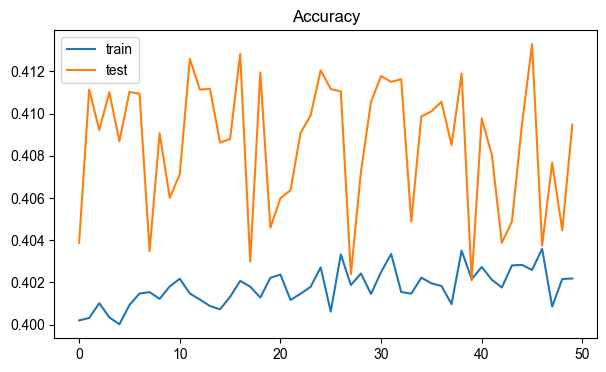

In [17]:
print(history.history.keys())
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial']  # 可以指定多个字体备选
plt.rcParams['axes.unicode_minus'] = False  # 用于解决负号显示问题
# plot history
plt.figure(figsize=(7, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Loss")
plt.show()

# plot history
plt.figure(figsize=(7, 4))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.title("Accuracy")
plt.show()


